## DVD Rental SQL Project

##### Analyze the DVD Rental Database and provide analysis with visualization. 

#### Languages Involved: 
- SQL
    - PostgreSQL
- Python 
    - Pandas
    - Matplotlib
    - Seaborn 

In [1]:
# Import all the necessary packages

import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Set up a connection with the database

conn = psycopg2.connect(
    dbname = 'dvdrental',
    user = 'postgres',
    password = 'Kimmy027!',
    port = 5432
)

In [3]:
# Test query to check if connection has been established
df = pd.read_sql("""
                 SELECT * 
                 FROM actor""", con = conn)
print(df)

     actor_id first_name     last_name             last_update
0           1   Penelope       Guiness 2013-05-26 14:47:57.620
1           2       Nick      Wahlberg 2013-05-26 14:47:57.620
2           3         Ed         Chase 2013-05-26 14:47:57.620
3           4   Jennifer         Davis 2013-05-26 14:47:57.620
4           5     Johnny  Lollobrigida 2013-05-26 14:47:57.620
..        ...        ...           ...                     ...
195       196       Bela        Walken 2013-05-26 14:47:57.620
196       197      Reese          West 2013-05-26 14:47:57.620
197       198       Mary        Keitel 2013-05-26 14:47:57.620
198       199      Julia       Fawcett 2013-05-26 14:47:57.620
199       200      Thora        Temple 2013-05-26 14:47:57.620

[200 rows x 4 columns]


/opt/homebrew/anaconda3/lib/python3.9/site-packages/pandas/io/sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


<div class="alert alert-info">

### **Analysis #1**

### Find out what the total number of rentals and total sales for each category.

**1. In pgAdmin, I set up my query so I am retrieving 4 columns that I need:**
- The category name (renamed as genre)
- The number of rentals per genre
- The total sales of each genre
- Added - The sale per rental for each genre


**2. The query consists of utilizing:**
- JOINS
- Subquery
- GROUP BY
- ORDER BY
- Aggregation Syntax
- It goes through 6 different tables in the database  

**3. Assign the query to a dataframe (cat_df)**

**4. Create a graph that shows the results of the query.**
- Use seaborn and matplotlib to create and customize the graph 

</div>


In [27]:


cat_df = pd.read_sql("""
                SELECT GENRE, num_rental, total_sales, total_sales/num_rental AS sales_per_rental
                FROM(
				    SELECT c.name AS GENRE, count(r.customer_id) AS num_rental, sum(p.amount) AS total_sales
                    FROM category c
                    JOIN film_category fc
                    ON c.category_id = fc.category_id
                    JOIN film f
                    ON fc.film_id = f.film_id
                    JOIN inventory i 
                    ON f.film_id = i.film_id
                    JOIN rental r
                    ON i.inventory_id = r.inventory_id
                    JOIN payment p
                    ON r.rental_id = p.rental_id
                    GROUP BY 1
                    ORDER BY 2 DESC)""", con = conn)
print(cat_df)

          genre  num_rental  total_sales  sales_per_rental
0        Sports        1081      4892.19          4.525615
1     Animation        1065      4245.31          3.986207
2        Action        1013      3951.84          3.901125
3        Sci-Fi         998      4336.01          4.344699
4        Family         988      3830.15          3.876670
5       Foreign         953      3934.47          4.128510
6         Drama         953      4118.46          4.321574
7   Documentary         937      3749.65          4.001761
8         Games         884      3922.18          4.436855
9           New         864      3966.38          4.590718
10     Children         861      3309.39          3.843659
11     Classics         860      3353.38          3.899279
12       Comedy         851      4002.48          4.703267
13       Horror         773      3401.27          4.400091
14       Travel         765      3227.36          4.218771
15        Music         750      3071.52          4.0953

/opt/homebrew/anaconda3/lib/python3.9/site-packages/pandas/io/sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


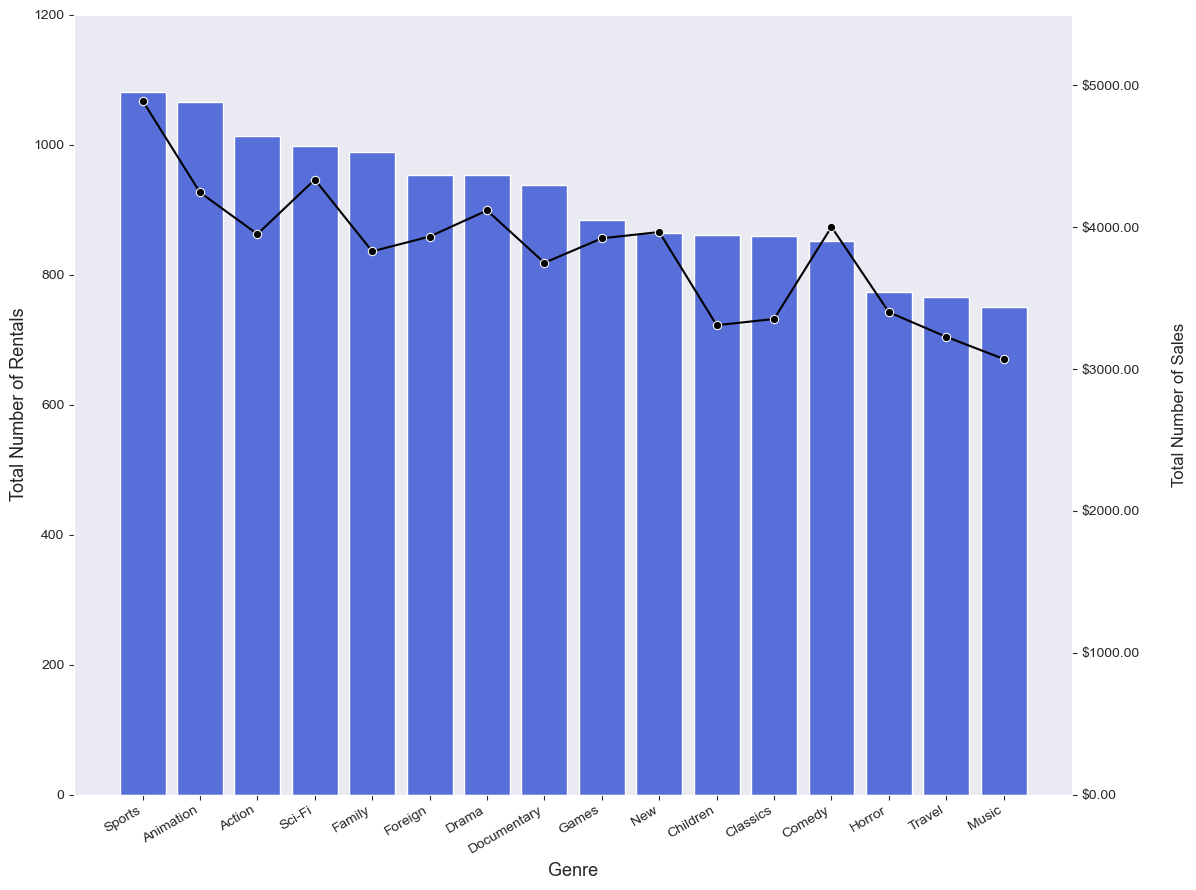

In [28]:
# Set up the figure 
sns.set_style('dark')
fig, (ax1) = plt.subplots(1,1, figsize = (12, 9))
ax2 = plt.twinx(ax = ax1)

# Make the graphs - one bar plot and one line plot 
sns.barplot(data = cat_df, 
             x = 'genre',
             y = 'num_rental',
             ax = ax1,
             label= 'num_rental',
             color= '#4361EE')

sns.lineplot(data = df,
            x = cat_df['genre'],
            y = cat_df['total_sales'],
            ax = ax2,
            color = 'black',
            marker='o',
            markerfacecolor='black')

# Customize the x and y axis
ax1.set_ylim(0,1200)
# ax1.set_yticklabels(labels = cat_df['genre'], rotation = 90)
ax1.set_xlabel("Genre", fontsize = 13)
ax1.set_ylabel("Total Number of Rentals", fontsize = 13)
ax1.xaxis.tick_bottom()
ax1.yaxis.tick_left()
ax2.yaxis.set_label_coords(1.1,1)


ax2.set_ylabel("Total Number of Sales", fontsize = 12)
ax2.yaxis.set_major_formatter('${x:1.2f}')
ax2.set_ylim(0, 5500)
ax2.yaxis.tick_right()

# Format the graph
fig.autofmt_xdate() # Auto format x-axis
plt.tight_layout() # Auto format graph size
plt.show()



In [57]:
## Compare rental counts between two stores by monthly rental 

rent_count_df = pd.read_sql("""
        WITH T1 AS(
	        SELECT EXTRACT(year from r.rental_date) AS year,
                        EXTRACT(month from r.rental_date) AS month,
		        s.store_id AS Store_ID,
		        COUNT(*) AS Rental_Count
	        FROM rental r
	        JOIN payment p
	        ON r.rental_id = p.rental_id
	        JOIN staff st
	        ON p.staff_id = st.staff_id
	        JOIN store s
	        ON st.store_id = s.store_id
	        GROUP BY 1, 2, 3
	        ORDER BY 1)

        SELECT CONCAT('0',month,'/',year) AS Date,
	        Store_ID,
	        Rental_Count
        FROM T1;""", 
        con = conn)
        
print(rent_count_df)


      date  store_id  rental_count
0  06/2005         1          1015
1  06/2005         2          1000
2  07/2005         1          3347
3  07/2005         2          3366
4  08/2005         1          2835
5  08/2005         2          2851
6  02/2006         1            95
7  02/2006         2            87


/opt/homebrew/anaconda3/lib/python3.9/site-packages/pandas/io/sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


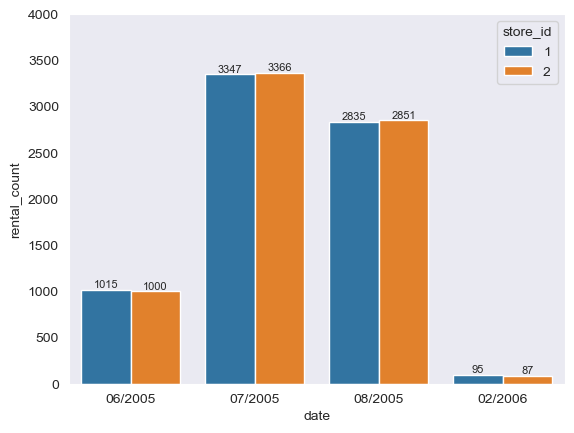

In [59]:

ax = sns.barplot(
                x = 'date',
                y = 'rental_count',
                hue = 'store_id',
                data = rent_count_df
                )
ax.set_ylim(0,4000)

for container in ax.containers:
    ax.bar_label(container, size = 8)